## [PoC] Rituximab MoA extraction

This demo performs an extraction of entities and relations contributing to the MoA for rituximab based on this 2010 FDA package insert: https://www.accessdata.fda.gov/drugsatfda_docs/label/2010/103705s5311lbl.pdf

See [ngly1-gpt#2](https://github.com/eric-czech/ngly1-gpt/issues/2) for the origins of this work, which was streamlined and ported to this project as a proof of concept.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import json
import logging
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import Image
from sklearn.manifold import TSNE
from txdnet import utils, llm
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
# Comment this out to rerun the extraction
# !source .env; python txdnet/cli.py extract_drug_moa_graph --output-filename=poc_rituximab_graph_json.tmp.txt 2>&1 | tee data/log/poc_rituximab_moa.log.txt

# Show the log with prompts + outputs
! cat data/log/poc_rituximab_moa.log.txt

2023-07-21 21:44:59,409|INFO|cli|extract_drug_moa_graph| Starting drug MoA extraction (model=gpt-4, input_filename=poc_rituximab_moa.txt, output_filename=poc_rituximab_graph_json.txt)
2023-07-21 21:44:59,410|INFO|llm|chat_completion| Prompt (temperature=None, model=gpt-4):
Text will be provided that contains information about the mechanism of action for a particular drug.

Identify any proteins, genes, variants, phenotypes, metabolites, pathways, biological functions or other biological entities of any kind that are linked to the pathogenesis of any diseases named as indications for the drug.

Requirements:

- Assume the intent of this information will be to build a graph/network containing these entities and the relations between them
- Ignore any information that cannot be implicated (directly or indirectly) in a mechanistic link between the drug and any one disease
- Include as much detail as possible about these mechanistic links by enumerating all entities and relations that are a

In [3]:
# Load the generated graph
with (utils.paths.data / "output" / "poc_rituximab_graph_json.txt").open("r", encoding="utf-8") as f:
    graph_json = f.read()
    graph = nx.node_link_graph(json.loads(graph_json), directed=True, multigraph=True)
    # Relabel integer ids used for token efficiency as text labels
    graph = nx.relabel_nodes(graph, {id: node['label'] for id, node in graph.nodes(data=True)})
graph, graph.number_of_nodes(), graph.number_of_edges()

(<networkx.classes.multidigraph.MultiDiGraph at 0x107dec310>, 29, 28)

In [4]:
# Extract node info and get embeddings/projections for them
nodes = (
    pd.DataFrame([
        {**dict(id=id), **node} 
        for id, node in graph.nodes(data=True)
    ]).set_index('id', drop=False)
    .assign(embedding=lambda df: [
        llm.text_embedding(f"{r.type}: {r.label}")
        for r in df.itertuples()
    ])
    .pipe(lambda df:
        pd.concat([
            df,
            pd.DataFrame(
                TSNE(n_components=2, random_state=0, init='pca', perplexity=10)
                .fit_transform(np.stack(df.embedding.values)),
                index=df.index
            ).add_prefix('X')
        ], axis=1)
    )
)
nodes

,id,label,type,embedding,X0,X1
id,,,,,,
Rituximab,Rituximab,Rituximab,Drug,"[-0.04215487465262413, -0.007634451612830162, ...",23.940153,8.892010
CD20,CD20,CD20,Protein,"[-0.036141760647296906, -0.015207260847091675,...",17.193481,14.197583
B lymphocytes,B lymphocytes,B lymphocytes,Cell type,"[-0.0253937765955925, -3.743806519196369e-05, ...",9.479943,-5.625710
Non-Hodgkin's lymphomas,Non-Hodgkin's lymphomas,Non-Hodgkin's lymphomas,Disease,"[-0.023586014285683632, 0.017757659777998924, ...",17.749304,1.044275
Hematopoietic stem cells,Hematopoietic stem cells,Hematopoietic stem cells,Cell type,"[-0.006492454558610916, -0.00403981888666749, ...",-0.450227,-6.023548
Pro-B-cells,Pro-B-cells,Pro-B-cells,Cell type,"[-0.016493244096636772, -0.018522175028920174,...",4.083808,3.737311
Normal plasma cells,Normal plasma cells,Normal plasma cells,Cell type,"[-0.022074533626437187, 0.0012927446514368057,...",15.756444,-7.974903
Calcium ion channel,Calcium ion channel,Calcium ion channel,Biological Function,"[-0.009608608670532703, -0.000218096625758335,...",-10.216134,35.201077
Cell cycle initiation,Cell cycle initiation,Cell cycle initiation,Biological Process,"[-0.01568414457142353, -0.017294451594352722, ...",-25.890646,12.040122


In [5]:
# Visualize the results

def plot_network(graph, nodes, pos):
    plt.figure(figsize=(24, 12))
    cmap = utils.get_colormap(nodes["type"].unique(), cmap="tab10")
    node_color=nodes["type"].map(cmap).fillna('grey')
    node_config = {"Drug": (.5, "black", "s", 200)}
    for k, g in nodes.groupby("type"):
        nodelist = g["id"].tolist()
        linewidths, edgecolors, node_shape, node_size = node_config.get(k, (0, "black", "o", 200))
        nx.draw_networkx_nodes(
            graph, pos, nodelist=nodelist, alpha=.5,
            linewidths=linewidths, edgecolors=edgecolors, node_shape=node_shape,
            node_size=node_size, node_color=node_color.loc[nodelist]
        )
    nx.draw_networkx_labels(graph, pos, labels={n: graph.nodes[n]["label"] for n in graph.nodes()}, font_size=8)
    nx.draw_networkx_edges(graph, pos, alpha=.1)
    nx.draw_networkx_edge_labels(graph, pos, alpha=.5, edge_labels={(e[0], e[1]): graph.edges[e].get("type", "None").lower().replace(' ', '_') for e in graph.edges}, font_size=8)

    plt.legend(handles=[
        Line2D([0], [0], marker='o', color=v, label=k, markerfacecolor=v, markersize=10, linewidth=0)
        for k, v in cmap.items()
    ], loc='upper right', bbox_to_anchor=(1.16, 1))
    plt.show()

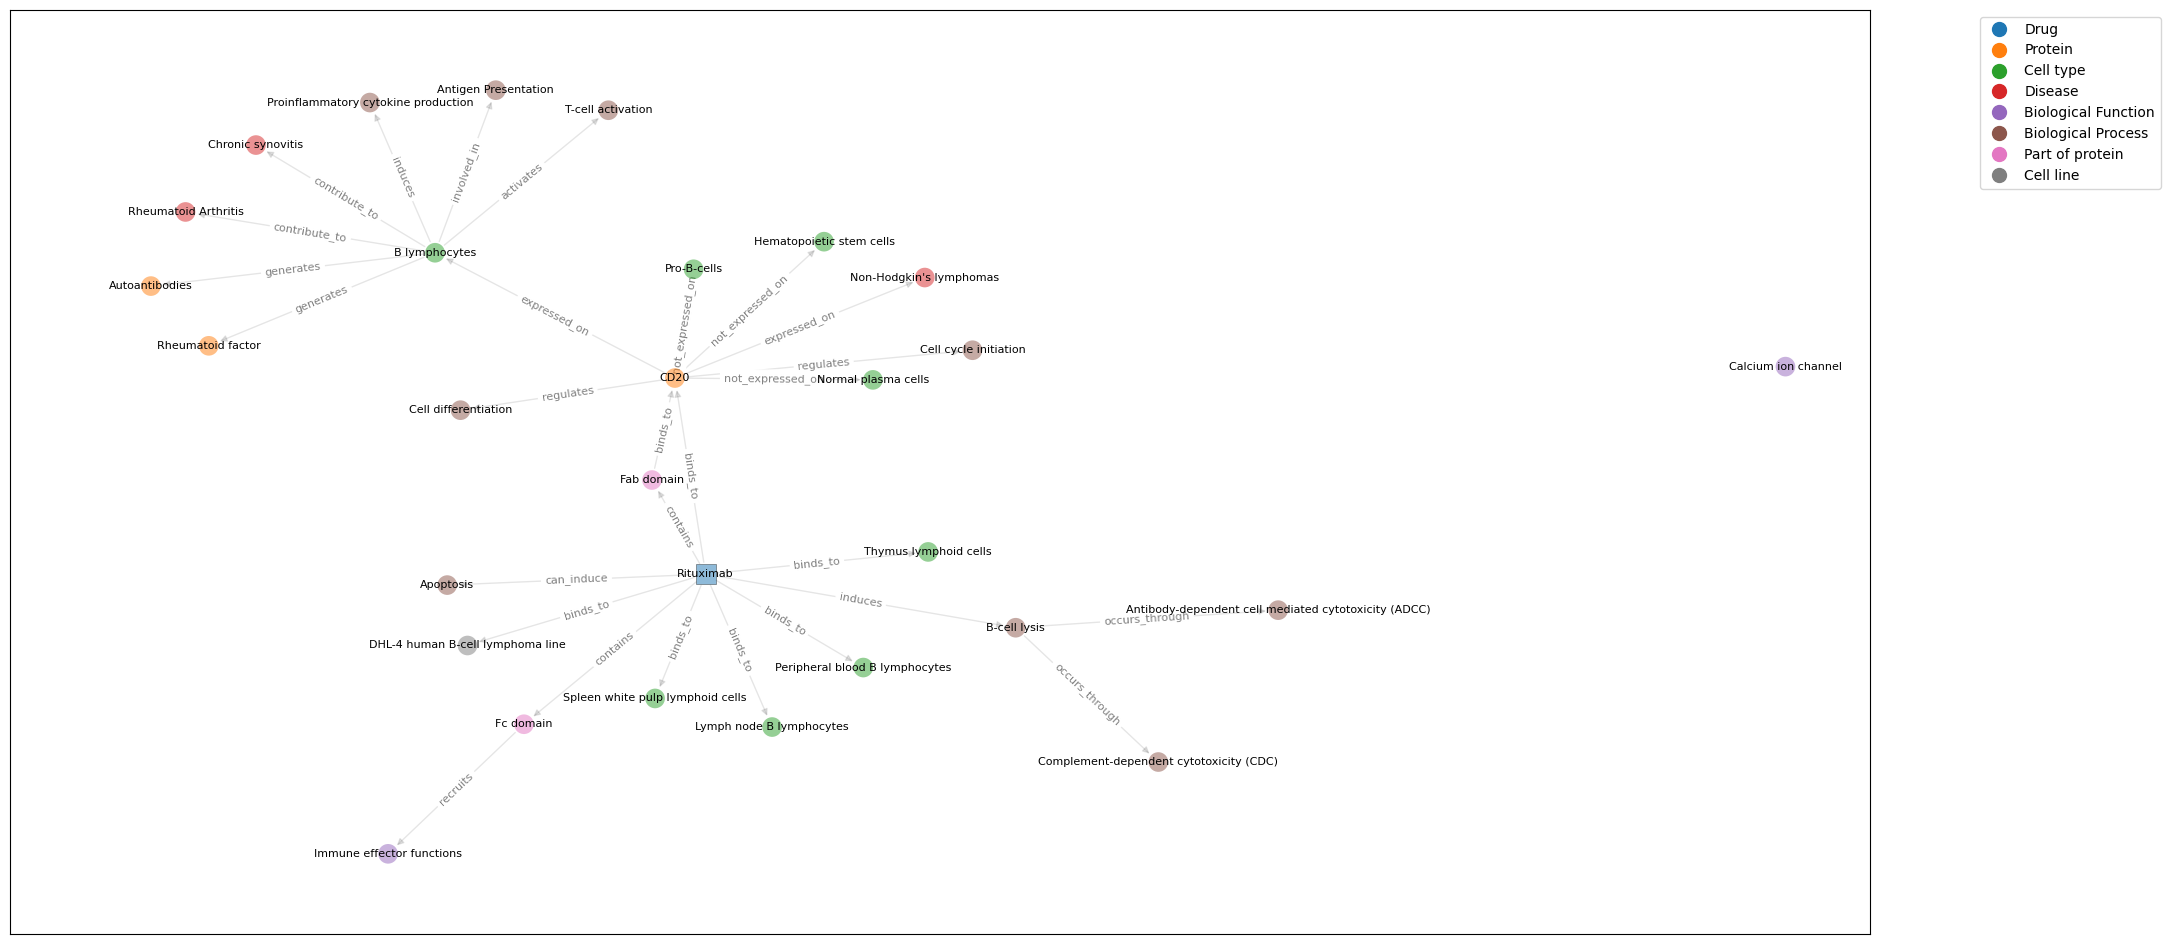

In [6]:
# Visualize with spatial layout
pos = nx.nx_agraph.graphviz_layout(graph, prog="neato")
plot_network(graph, nodes, pos)

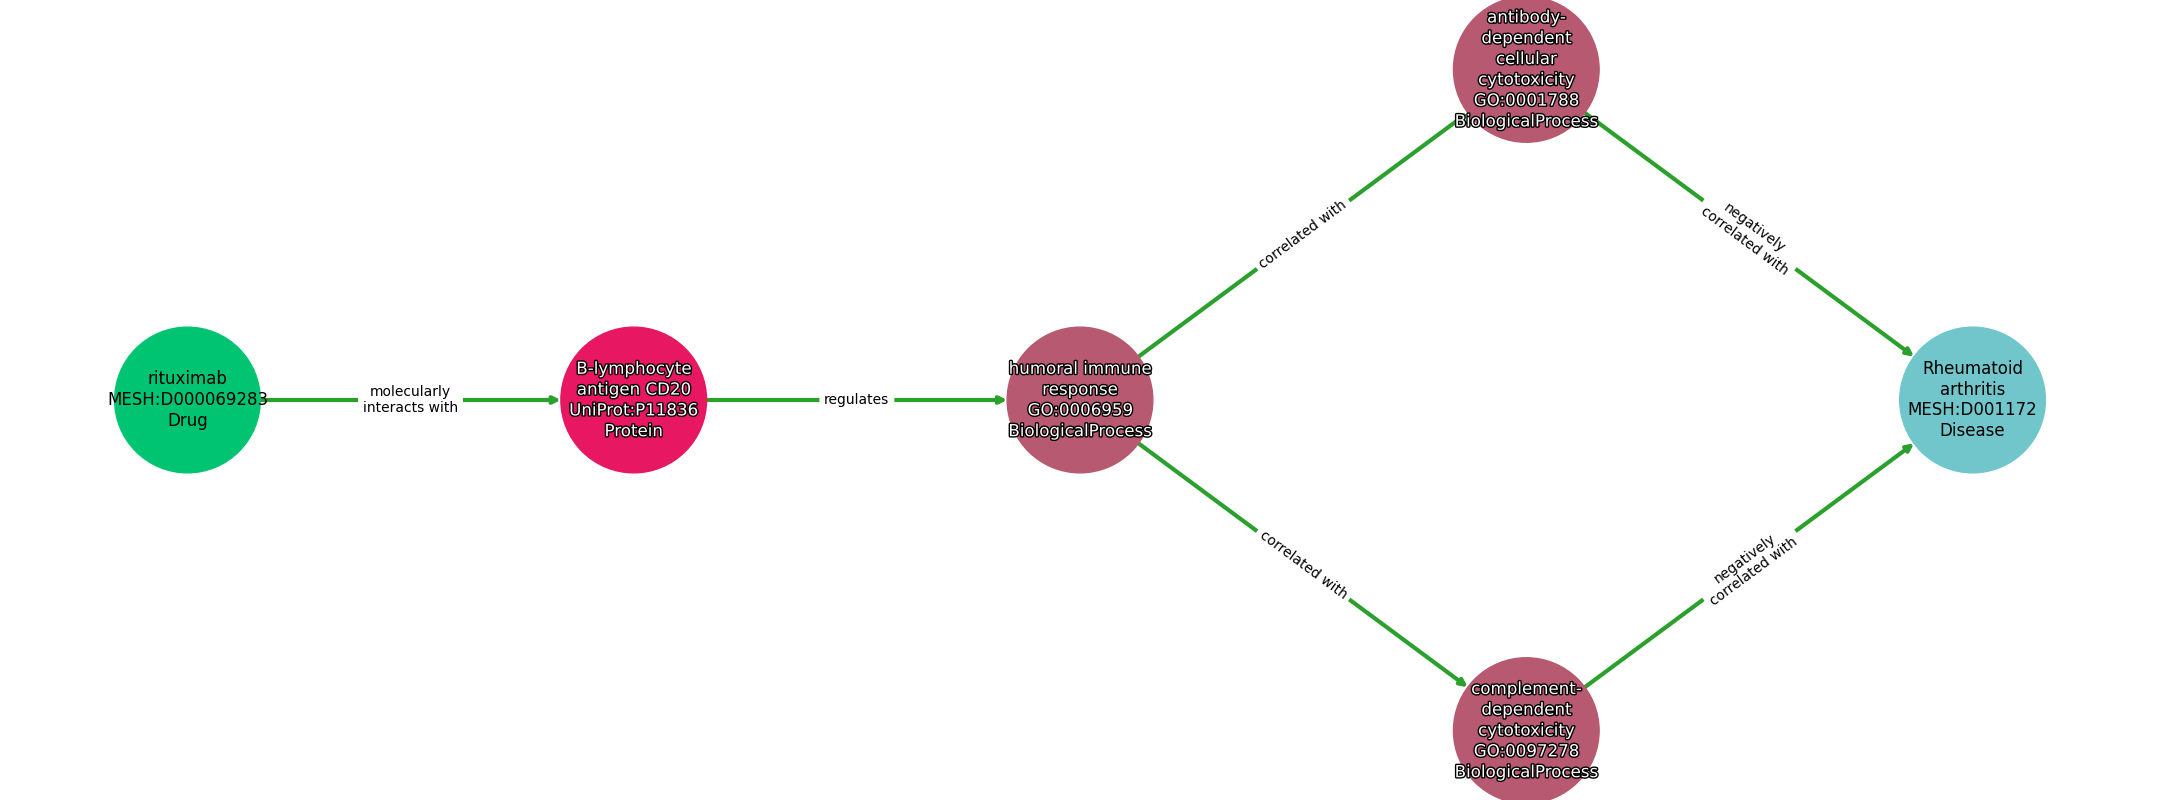

In [7]:
# Compare to DrugMechDB result at https://sulab.github.io/DrugMechDB/db00240-mesh-d001172-1.html
Image(filename='txdnet/notebooks/images/drugmechdb_rituximab_moa.png', width=1600)

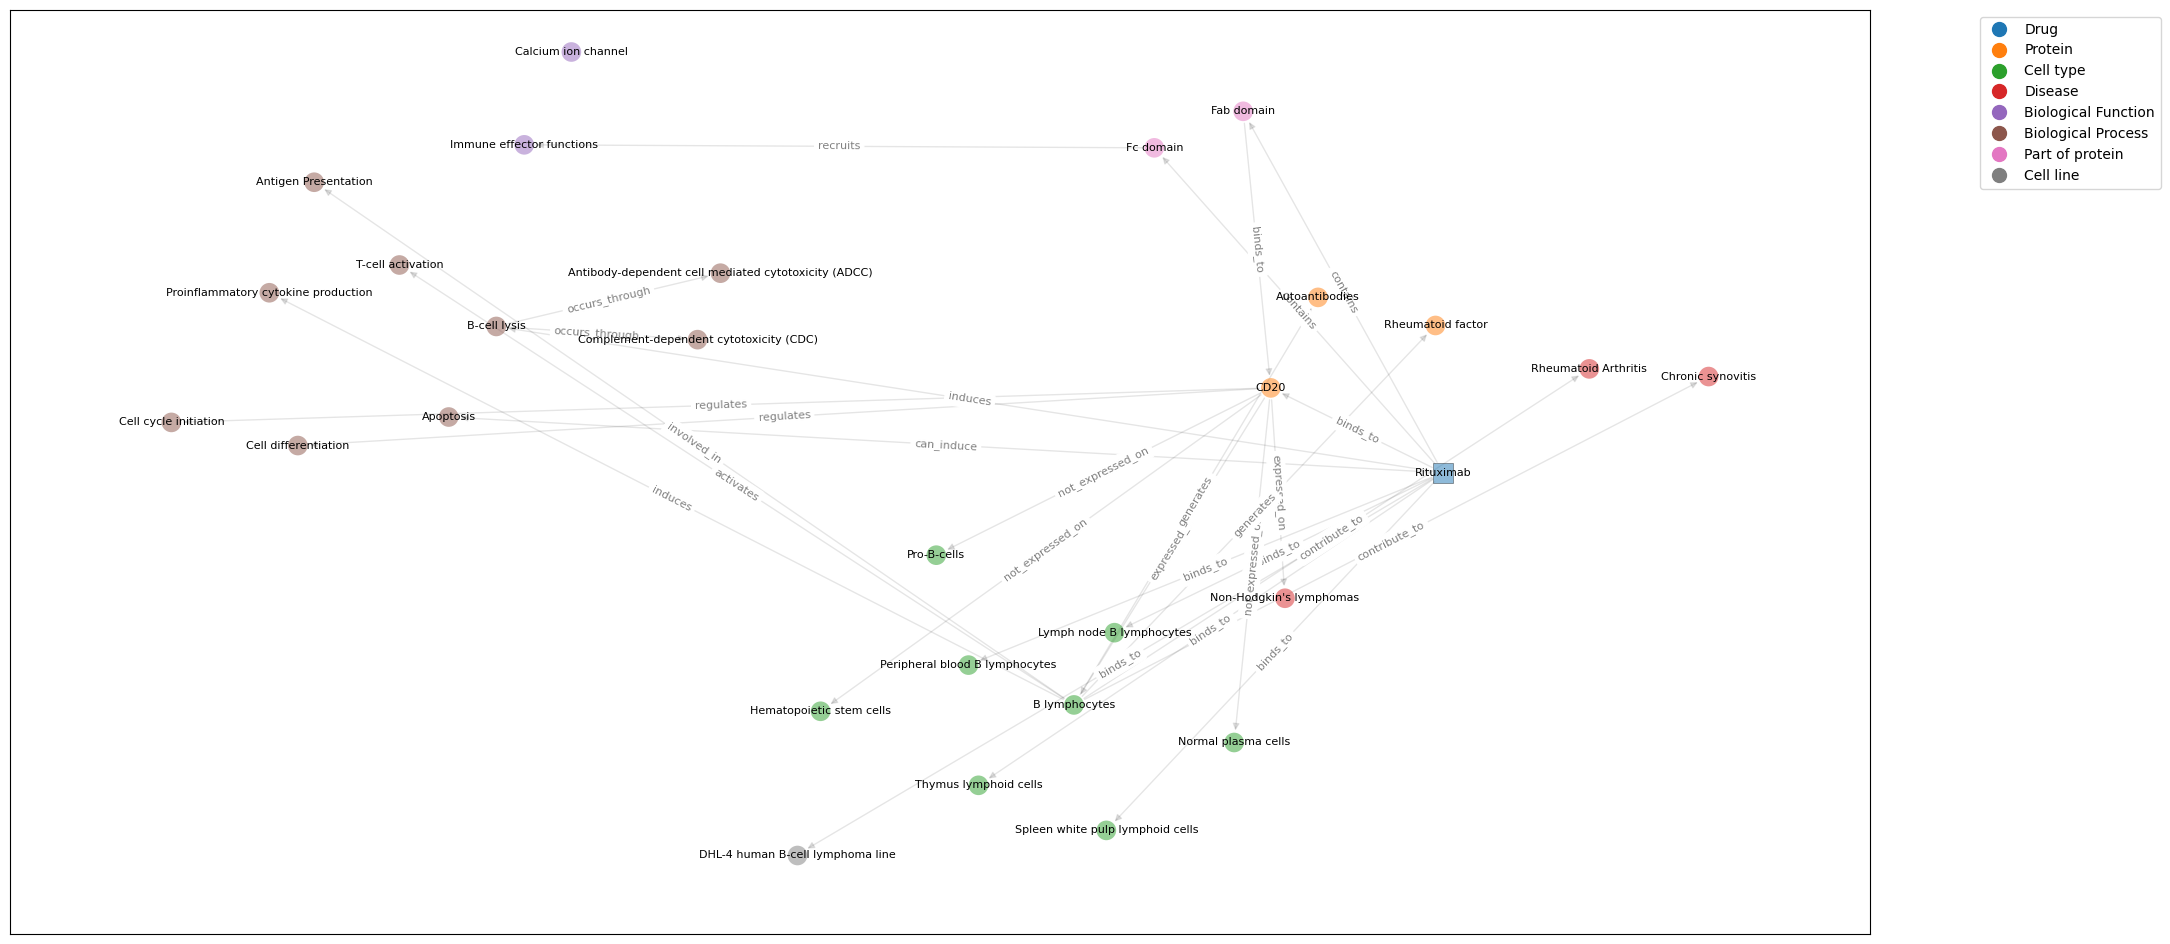

In [8]:
# Visualize with semantic layout
pos = {
    r.id: (r.X0, r.X1)
    for r in nodes.itertuples()
}
plot_network(graph, nodes, pos)